<a href="https://colab.research.google.com/github/Aldistwn29/Projek_deteksi_penyakit_tanaman_CitraDigital/blob/main/Projek_Deteksi_Penyakit_Mangga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libarary

In [ ]:
!pip install request
!pip install Pillow
!pip install matplotlib
!pip install numpy
!pip install --upgrade tensorflow

ERROR: Could not find a version that satisfies the requirement request (from versions: none)
ERROR: No matching distribution found for request
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Steps 1 impoert library

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from sklearn.model_selection import train_test_split

# Steps 2: Membuat dan mengatur dataset

In [ ]:
import requests
import zipfile
import io

dataset_url = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxsnvwty3r-1.zip'
# definisikan direktory untuk menyimpan dataset
destination_dir = '/content/drive/MyDrive/Datasets/MangoLeafBD_Dataset'
# buat direktory tujuan jika belum ada
!mkdir -p {destination_dir}
# dowloadn zip file
response = requests.get(dataset_url)
dataset_zip = zipfile.ZipFile(io.BytesIO(response.content))
# tutup zip file
dataset_zip.close()
print("Dataset berhasil di download")

Dataset berhasil di download


In [ ]:
import os
import requests
import zipfile
import io
from sklearn.model_selection import train_test_split
import shutil

# Define the dataset URL
dataset_url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxsnvwty3r-1.zip"

# Define the root directory in Google Drive
destination_dir = "/content/drive/MyDrive/Datasets/MangoLeafBD_Dataset"

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Download and extract the dataset
print("Downloading dataset...")
response = requests.get(dataset_url)
zip_path = os.path.join(destination_dir, "MangoLeafBD_Dataset.zip")
with open(zip_path, "wb") as f:
    f.write(response.content)

print("Extracting dataset...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(destination_dir)

# Remove the zip file after extraction
os.remove(zip_path)
print("Dataset downloaded and extracted successfully.")

# Define directories for train and validation datasets
train_dir = os.path.join(destination_dir, "MangoLeafBD_Train")
val_dir = os.path.join(destination_dir, "MangoLeafBD_Val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Define the root dataset directory (after extraction)
root_dir = os.path.join(destination_dir, "MangoLeafBD Dataset")

# Define the class names
class_names = [
    "Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
    "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"
]

# Define the train-validation split ratio
val_split = 0.2

# Organize dataset into train and validation folders
for class_name in class_names:
    class_dir = os.path.join(root_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    # Ensure class directories exist
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # List all image files in the class directory
    if os.path.exists(class_dir):
        images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(images) == 0:
            print(f"No images found in class directory: {class_dir}")
            continue

        # Split images into train and validation sets
        train_images, val_images = train_test_split(images, test_size=val_split, random_state=42)

        # Move images to train and validation folders
        for image in train_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(train_class_dir, image)
            shutil.move(src, dst)

        for image in val_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(val_class_dir, image)
            shutil.move(src, dst)

        print(f"Class {class_name}: {len(train_images)} images for training, {len(val_images)} images for validation")
    else:
        print(f"Class directory not found: {class_dir}")

print("Dataset organized into train and validation folders.")

Extracting dataset...
Dataset downloaded and extracted successfully.
Class Anthracnose: 400 images for training, 100 images for validation
Class Bacterial Canker: 400 images for training, 100 images for validation
Class Cutting Weevil: 400 images for training, 100 images for validation
Class Die Back: 400 images for training, 100 images for validation
Class Gall Midge: 400 images for training, 100 images for validation
Class Healthy: 400 images for training, 100 images for validation
Class Powdery Mildew: 400 images for training, 100 images for validation
Class Sooty Mould: 400 images for training, 100 images for validation
Dataset organized into train and validation folders.


# Step 3: Data Augmentasi

In [ ]:
batch_size = 16
image_size = (244, 244)

# definisikan data generator dengan data augmentasi untuk training dan validation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range =0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Datasets/MangoLeafBD_Dataset/MangoLeafBD_Train',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Datasets/MangoLeafBD_Dataset/MangoLeafBD_Val',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


# Steps 4: Modeling CNN

In [ ]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(244, 244, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 242, 242, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 121, 121, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 119, 119, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 59, 59, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 57, 57, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 26, 26, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      22,151,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,544,200 (86.00 MB)

 Trainable params: 22,544,200 (86.00 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [ ]:
# Definisikan epoch
epochs = 20

# latih model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(val_generator)
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - accuracy: 0.2510 - loss: 1.8938 - val_accuracy: 0.3688 - val_loss: 1.5534
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 733s 3s/step - accuracy: 0.5613 - loss: 1.1394 - val_accuracy: 0.7437 - val_loss: 0.7229
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 93us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 683s 3s/step - accuracy: 0.7799 - loss: 0.5669 - val_accuracy: 0.8975 - val_loss: 0.3079
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 686s 3s/step - accuracy: 0.8698 - loss: 0.3595 - val_accuracy: 0.8300 - val_loss: 0.3737
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 93us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 680s 3s/step - accuracy: 0.8559 - loss: 0.3906 - val_accuracy: 0.9388 - val_loss: 0.1771
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 93us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 680s 3s/step - accuracy: 0.8872 - loss: 0.2993 - val_accuracy: 0.9588 - v

# Step 6: Evaluasi the Model

In [ ]:
train_metrics = model.evaluate(train_generator)
val_metrics = model.evaluate(val_generator)

print("Metrics for Training Set:")
print(f"loss:{train_metrics[0]}")
print(f"Accuracy:{train_metrics[1]}")

print("\nMetrics for Validation Set:")
print(f"loss:{val_metrics[0]}")
print(f"Accuracy:{val_metrics[1]}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9395 - loss: 0.1729
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 895ms/step - accuracy: 0.9419 - loss: 0.1912
Metrics for Training Set:
loss:0.17285732924938202
Accuracy:0.9378125071525574

Metrics for Validation Set:
loss:0.16033954918384552
Accuracy:0.9437500238418579


# Step 7: Save Model

In [ ]:
# Save model
model.save('/content/drive/MyDrive/Datasets/mango_leaf_disease_model.h5')

# Step 8: Load Model

In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/Datasets/mango_leaf_disease_model.h5')

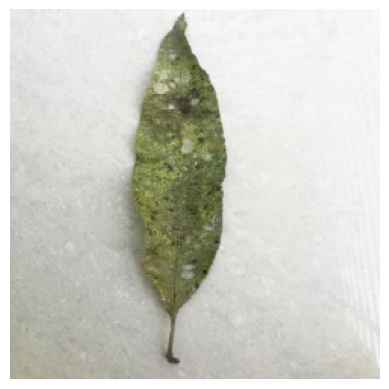

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediksi kelas: Sooty Mould
Probabilitas: 0.9878746867179871


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

new_image_path = '/content/test_2.jpg'
image_size = (244, 244)

# Load and preprocessing the new image
img = image.load_img(new_image_path, target_size=image_size)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

# Menampilkan gambar
plt.imshow(img[0])
plt.axis('off')
plt.show()

# Membuat prediksi
predictions = loaded_model.predict(img)

# Datapatkan label kelas dan probabilitas yang sesuai
class_labels = train_generator.class_indices
class_labels = {v:k for k, v in class_labels.items()}

# Menemukkan indeks kelas dengan probabilitas tertinggi
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# tampilkan hasil
print(f"Prediksi kelas: {predicted_class}")
print(f"Probabilitas: {predicted_probability}")